In [2]:
import pandas as pd
import numpy as np
import string
from scipy.stats import pearsonr
import re
from string import punctuation


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import re
from string import punctuation


from collections import Counter
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
sample_joy = pd.read_excel(r"C:\Users\kushal\Desktop\bennet dataset\Task 1 data\EI-reg-En-train (1)\EI-reg-En-joy-train.xlsx")

In [4]:
sample_joy.head()

,ID,Tweet,Affect Dimension,Intensity Score
0,2017-En-30793,"@david_garrett Quite saddened.....no US dates,...",joy,0.140
1,2017-En-30070,2 days until #GoPackGo and 23 days until #GoGi...,joy,0.792
2,2017-En-30692,Positive #psychology research shows salespeopl...,joy,0.274
3,2017-En-31323,As the birds chirp and the cows moo we need to...,joy,0.480
4,2017-En-31553,Howling with laughter at â€œWELL DONE BEZZA!â€...,joy,0.940


In [5]:
sample_joy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 4 columns):
ID                  1616 non-null object
Tweet               1616 non-null object
Affect Dimension    1616 non-null object
Intensity Score     1616 non-null float64
dtypes: float64(1), object(3)
memory usage: 50.6+ KB


In [6]:
sample_joy['length'] = sample_joy['Tweet'].apply(len)
sample_joy.head()

,ID,Tweet,Affect Dimension,Intensity Score,length
0,2017-En-30793,"@david_garrett Quite saddened.....no US dates,...",joy,0.140,137
1,2017-En-30070,2 days until #GoPackGo and 23 days until #GoGi...,joy,0.792,72
2,2017-En-30692,Positive #psychology research shows salespeopl...,joy,0.274,143
3,2017-En-31323,As the birds chirp and the cows moo we need to...,joy,0.480,104
4,2017-En-31553,Howling with laughter at â€œWELL DONE BEZZA!â€...,joy,0.940,62


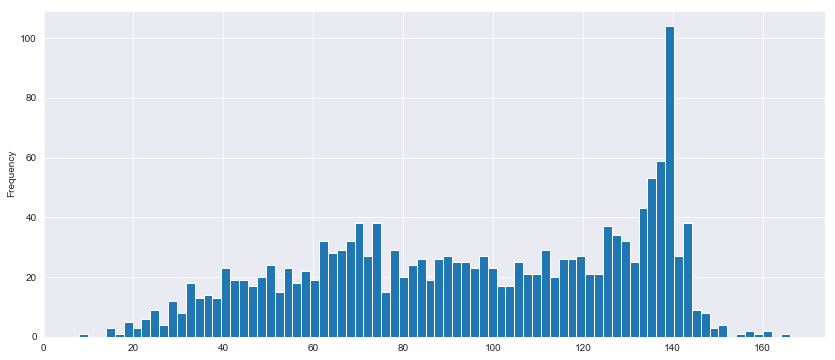

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,6))
sample_joy['length'].plot(bins=80, kind='hist')

In [8]:
# get most common words in training dataset
all_words = []
for line in list(sample_joy['Tweet']):
    words = line.split()
    
for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('and', 3),
 ('in', 2),
 ('i', 1),
 ('think', 1),
 ('some', 1),
 ('of', 1),
 ('our', 1),
 ('most', 1),
 ('spiritually', 1),
 ('weighty', 1)]

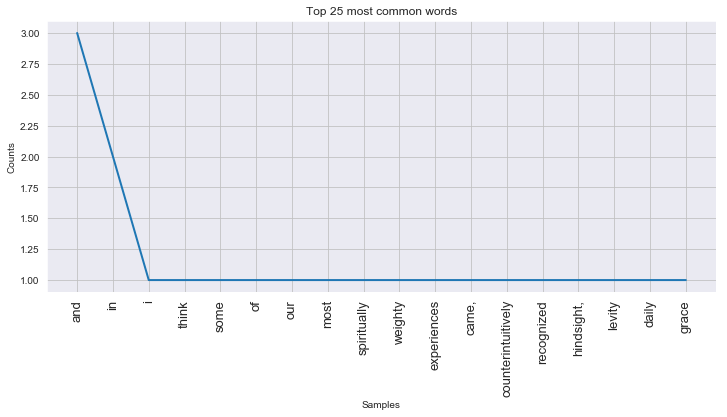

Text(0.5, 1.0, 'log-log plot of words frequency')

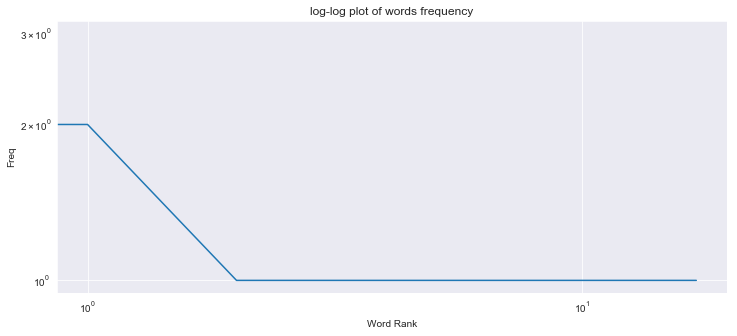

In [9]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25)
# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [10]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove chines words
    tweet = re.sub(r'˜¥\w*','', tweet)
    tweet = re.sub(r'˜€\w*','', tweet)
    tweet = re.sub(r'˜¤\w*','', tweet)
    tweet = re.sub(r'˜ªðÿ\w*','', tweet)
    tweet = re.sub(r'ðÿ™\w*','', tweet)
    tweet = re.sub(r'\\\w*','', tweet)
    tweet = re.sub(r'±\w*','', tweet)
    tweet = re.sub(r'\w*','', tweet)
    tweet = re.sub(r'™„˜­\w*','', tweet)
    tweet = re.sub(r'ðÿ§€\w*','', tweet)
    tweet = re.sub(r'‘šðÿ¼\w*','', tweet)
    tweet = re.sub(r'ðÿ•\w*','', tweet)
    tweet = re.sub(r'€¢\w*','', tweet)
    tweet = re.sub(r'ã©\w*','', tweet)
    
    tweet = re.sub(r'\w*','',tweet)
    
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
sample_joy['Tweet'] = sample_joy['Tweet'].apply(processTweet)
# preview some cleaned tweets
sample_joy['Tweet'].head(1000)

0      quite saddened dates joyous anticipation atten...
1                     days until and days until excited 
2      positive research shows salespeople who score ...
3      the birds chirp and the cows moo need listen t...
4             howling with laughter €œwell done bezza € 
5                                      afternoon delight
6      defo hearty root veg gratin nice comfort food ...
7      remember and reflect reginald denny night much...
8                                       that the spirit 
9                                                  also 
10     thank you for that the notification came the n...
11     they ain going away and don want see them hurt...
12     when havent learned swim ¤” but you keep worki...
13                     evening all don forget tonight  
14     close the end revision taking this story love ...
15         mirana told shut when was singing along glee 
16                                       open mind kind 
17     ”¥’ its lit having cla

In [11]:
# drop duplicates
sample_joy= sample_joy.drop_duplicates('Tweet')
sample_joy.shape

(1327, 5)

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kushal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# show stop words examples
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)

("i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it ",
 179)

In [14]:
sample_joy["Tweet"].head(1000)

0       quite saddened dates joyous anticipation atten...
1                      days until and days until excited 
2       positive research shows salespeople who score ...
3       the birds chirp and the cows moo need listen t...
4              howling with laughter €œwell done bezza € 
5                                       afternoon delight
6       defo hearty root veg gratin nice comfort food ...
7       remember and reflect reginald denny night much...
8                                        that the spirit 
9                                                   also 
10      thank you for that the notification came the n...
11      they ain going away and don want see them hurt...
12      when havent learned swim ¤” but you keep worki...
13                      evening all don forget tonight  
14      close the end revision taking this story love ...
15          mirana told shut when was singing along glee 
16                                        open mind kind 
17      ”¥’ 

In [15]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]




# -------------------------------------------

# tokenize message column and create a column for tokens
sample_joy = sample_joy.copy()
sample_joy['tokens'] = sample_joy['Tweet'].apply(text_process) # tokenize style


sample_joy.head()

,ID,Tweet,Affect Dimension,Intensity Score,length,tokens
0,2017-En-30793,quite saddened dates joyous anticipation atten...,joy,0.140,137,"[quite, saddened, dates, joyous, anticipation,..."
1,2017-En-30070,days until and days until excited,joy,0.792,72,"[days, days, excited]"
2,2017-En-30692,positive research shows salespeople who score ...,joy,0.274,143,"[positive, research, shows, salespeople, score..."
3,2017-En-31323,the birds chirp and the cows moo need listen t...,joy,0.480,104,"[birds, chirp, cows, moo, need, listen, sound,..."
4,2017-En-31553,howling with laughter €œwell done bezza €,joy,0.940,62,"[howling, laughter, €œwell, done, bezza, €]"


In [16]:
from wordcloud import WordCloud

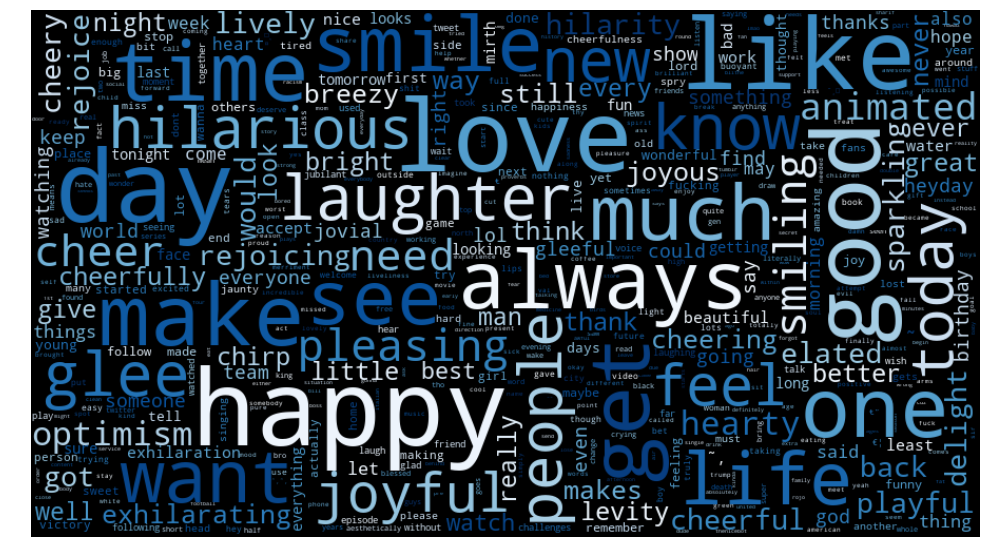

In [17]:
# split sentences to get individual words
all_words = []
for line in sample_joy['tokens']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
# vectorize
bow_transformer_uni = CountVectorizer(analyzer=text_process,lowercase=False, token_pattern=r'\S+', ngram_range=(1, 1)).fit(sample_joy['Tweet'])
bow_transformer_bi = CountVectorizer(analyzer=text_process,lowercase=False, token_pattern=r'\S+', ngram_range=(2, 2)).fit(sample_joy['Tweet'])
bow_transformer_uni_bi = CountVectorizer(analyzer=text_process,lowercase=False, token_pattern=r'\S+', ngram_range=(1, 2)).fit(sample_joy['Tweet'])
# print total number of vocab words
#print(len(bow_transformer.vocabulary_))
# output
#6865
# example of vectorized text
#sample_tweet = sample_anger['Tweet'][211]
#print(sample_tweet)
#print('\n')
# vector representation
#bow_sample = bow_transformer.transform([sample_tweet])
#print(bow_sample)
#print('\n')

In [20]:
#transform the entire DataFrame of messages
messages_bow_uni = bow_transformer_uni.transform(sample_joy['Tweet'])
messages_bow_bi = bow_transformer_bi.transform(sample_joy['Tweet'])
messages_bow_uni_bi = bow_transformer_uni_bi.transform(sample_joy['Tweet'])
# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix of messages_bow_uni: ', messages_bow_uni.shape)
print('Amount of Non-Zero occurences in message_bow_uni: ', messages_bow_uni.nnz)



Shape of Sparse Matrix of messages_bow_uni:  (1327, 4115)
Amount of Non-Zero occurences in message_bow_uni:  9926


In [21]:
#Preparing training & test data (uni & bi-grams)
from sklearn.model_selection import train_test_split 
X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(messages_bow_uni, sample_joy["Intensity Score"], test_size=0.33, random_state=42)
X_train_uni_bi, X_test_uni_bi, y_train_uni_bi, y_test_uni_bi = train_test_split(messages_bow_uni_bi, sample_joy["Intensity Score"], test_size=0.33, random_state=42)

In [22]:
pca = PCA(n_components=500)
X_train_uni_pca = pca.fit_transform(X_train_uni.toarray())
X_test_uni_pca = pca.transform(X_test_uni.toarray())



X_train_uni_bi_pca = pca.fit_transform(X_train_uni_bi.toarray())
X_test_uni_bi_pca = pca.transform(X_test_uni_bi.toarray())


In [23]:
def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train) # Train the model using the training sets
    y_pred = model.predict(X_test) # Make predictions using the testing set
    y_pred_train = model.predict(X_train)
    r2 = r2_score(y_test, y_pred)
    
    r2_train = r2_score(y_train, y_pred_train)
    rmse = mean_squared_error(y_test, y_pred)
    rmse_train = mean_squared_error(y_train, y_pred_train)
    print("Train: R2 : {0:f}, RMSE : {1:f}".format( r2_train, rmse_train ) )
    print("Test: R2 : {0:f}, RMSE : {1:f}".format( r2, rmse ) )
    return (rmse, r2)

alpha = 0.1
Train: R2 : 0.985564, RMSE : 0.000646
Test: R2 : 0.049094, RMSE : 0.043568
Train: R2 : 0.707406, RMSE : 0.013090
Test: R2 : 0.315816, RMSE : 0.031347
Train: R2 : 0.985564, RMSE : 0.000646
Test: R2 : 0.049094, RMSE : 0.043568
Train: R2 : 0.713980, RMSE : 0.012796
Test: R2 : 0.321434, RMSE : 0.031090
alpha = 0.8551724137931034
Train: R2 : 0.942513, RMSE : 0.002572
Test: R2 : 0.244264, RMSE : 0.034626
Train: R2 : 0.702692, RMSE : 0.013301
Test: R2 : 0.318038, RMSE : 0.031246
Train: R2 : 0.942513, RMSE : 0.002572
Test: R2 : 0.244264, RMSE : 0.034626
Train: R2 : 0.709014, RMSE : 0.013018
Test: R2 : 0.323207, RMSE : 0.031009
alpha = 1.610344827586207
Train: R2 : 0.901831, RMSE : 0.004392
Test: R2 : 0.282191, RMSE : 0.032888
Train: R2 : 0.693524, RMSE : 0.013711
Test: R2 : 0.317446, RMSE : 0.031273
Train: R2 : 0.901831, RMSE : 0.004392
Test: R2 : 0.282191, RMSE : 0.032888
Train: R2 : 0.699423, RMSE : 0.013447
Test: R2 : 0.322174, RMSE : 0.031056
alpha = 2.3655172413793104
Train: R

Train: R2 : 0.467279, RMSE : 0.023833
Test: R2 : 0.236111, RMSE : 0.034999
alpha = 19.73448275862069
Train: R2 : 0.509328, RMSE : 0.021952
Test: R2 : 0.236164, RMSE : 0.034997
Train: R2 : 0.459265, RMSE : 0.024191
Test: R2 : 0.231741, RMSE : 0.035200
Train: R2 : 0.509328, RMSE : 0.021952
Test: R2 : 0.236164, RMSE : 0.034997
Train: R2 : 0.460719, RMSE : 0.024126
Test: R2 : 0.233206, RMSE : 0.035132
alpha = 20.489655172413794
Train: R2 : 0.501490, RMSE : 0.022302
Test: R2 : 0.233323, RMSE : 0.035127
Train: R2 : 0.452961, RMSE : 0.024473
Test: R2 : 0.228948, RMSE : 0.035327
Train: R2 : 0.501490, RMSE : 0.022302
Test: R2 : 0.233323, RMSE : 0.035127
Train: R2 : 0.454364, RMSE : 0.024411
Test: R2 : 0.230376, RMSE : 0.035262
alpha = 21.244827586206895
Train: R2 : 0.493934, RMSE : 0.022640
Test: R2 : 0.230549, RMSE : 0.035254
Train: R2 : 0.446850, RMSE : 0.024747
Test: R2 : 0.226225, RMSE : 0.035452
Train: R2 : 0.493934, RMSE : 0.022640
Test: R2 : 0.230549, RMSE : 0.035254
Train: R2 : 0.448205

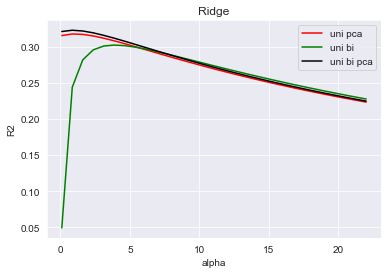

the best R^2 is 0.3232069858169505 with alpha=0.8551724137931034 and training data: uni & bi with PCA


In [23]:
r2_uni, r2_uni_pca, r2_uni_bi, r2_uni_bi_pca = [], [], [], []
max_r2, best_alpha, best_training_data = 0, 0, ''    
    
alphas = np.linspace(0.1,22,30)
for a in alphas:
    print('alpha = ' + str(a))
    # fit & evaluate uni-gram without pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_uni, y_train_uni, X_test_uni, y_test_uni)[1]
    r2_uni.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni'
    # fit & evaluate uni-gram with pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_uni_pca, y_train_uni, X_test_uni_pca, y_test_uni)[1]
    r2_uni_pca.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni with PCA'
    # fit & evaluate uni & bi-gram without pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_uni_bi, y_train_uni_bi, X_test_uni_bi, y_test_uni_bi)[1]
    r2_uni_bi.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni & bi'
    # fit & evaluate uni & bi-gram with pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model,X_train_uni_bi_pca, y_train_uni_bi, X_test_uni_bi_pca, y_test_uni_bi)[1]
    r2_uni_bi_pca.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni & bi with PCA'

plt.plot(alphas,r2_uni_pca,'r', label='uni pca')
#plt.plot(alphas,r2_uni,'b', label='uni')
plt.plot(alphas,r2_uni_bi,'g', label='uni bi')
plt.plot(alphas,r2_uni_bi_pca,'k', label='uni bi pca')
plt.legend(loc='upper right', numpoints = 1)
plt.xlabel('alpha')
plt.ylabel('R2')
plt.title('Ridge')
plt.show()

#print the best C and training data
print('the best R^2 is ' + str(max_r2) + ' with alpha=' + str(best_alpha) + ' and training data: ' + best_training_data)


In [25]:
best_ridge_model = linear_model.Ridge(alpha=0.8551724137931034, random_state=seed)
best_ridge_model.fit(X_train_uni_bi_pca, y_train_uni_bi) # Train the model using the training sets
y_pred = best_ridge_model.predict(X_test_uni_bi_pca) # Make predictions using the testing set
pearson = pearsonr(y_test_uni_bi, y_pred)
print('Pearson score for Ridge = ' + str(pearson[0]))

Pearson score for Ridge = 0.5696009043974872


l1_ratio = 0.1


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.2


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.30000000000000004


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.4


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.5


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


l1_ratio = 0.6


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.7000000000000001


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.8


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 0.9


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

l1_ratio = 1.0


C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\kushal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to in

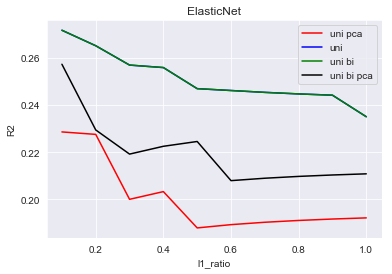

the best R^2 is 0.2716207768073827 with l1_ratio=0.1 and training data: uni


In [26]:
r2_uni, r2_uni_pca, r2_uni_bi, r2_uni_bi_pca = [], [], [], []
max_r2, best_l1_ratio, best_training_data = 0, 0, ''    
 
l1_ratios = np.linspace(0.1,1,10)
for l in l1_ratios:
    print('l1_ratio = ' + str(l))
    ENet = linear_model.ElasticNetCV(l1_ratio=l,eps=1e-6,cv=5,random_state=seed)
    # fit & evaluate uni-gram without pca
    ENet.fit(X_train_uni, y_train_uni)
    r2 = ENet.score(X_test_uni, y_test_uni)
    r2_uni.append(r2)
    if max_r2 < r2: max_r2, best_l1_ratio, best_training_data = r2, l, 'uni'
    # fit & evaluate uni-gram with pca
    ENet.fit(X_train_uni_pca, y_train_uni)
    r2 = ENet.score(X_test_uni_pca, y_test_uni)
    r2_uni_pca.append(r2)
    if max_r2 < r2: max_r2, best_l1_ratio, best_training_data = r2, l, 'uni with PCA'
    # fit & evaluate uni & bi-gram without pca
    ENet.fit(X_train_uni_bi, y_train_uni_bi)
    r2 = ENet.score(X_test_uni_bi, y_test_uni_bi)
    r2_uni_bi.append(r2)
    if max_r2 < r2: max_r2, best_l1_ratio, best_training_data = r2, l, 'uni & bi'
    # fit & evaluate uni & bi-gram with pca
    ENet.fit(X_train_uni_bi_pca, y_train_uni_bi)
    r2 = ENet.score(X_test_uni_bi_pca, y_test_uni_bi)
    r2_uni_bi_pca.append(r2)
    if max_r2 < r2: max_r2, best_l1_ratio, best_training_data = r2, l, 'uni & bi with PCA'

plt.plot(l1_ratios,r2_uni_pca,'r', label='uni pca')
plt.plot(l1_ratios,r2_uni,'b', label='uni')
plt.plot(l1_ratios,r2_uni_bi,'g', label='uni bi')
plt.plot(l1_ratios,r2_uni_bi_pca,'k', label='uni bi pca')
plt.legend(loc='upper right', numpoints = 1)
plt.xlabel('l1_ratio')
plt.ylabel('R2')
plt.title('ElasticNet')
plt.show()

#print the best l1_ratio and training data
print('the best R^2 is ' + str(max_r2) + ' with l1_ratio=' + str(best_l1_ratio) + ' and training data: ' + best_training_data)


In [27]:
best_Elastic_net_model = linear_model.ElasticNet('l1_ratio=0.1', random_state=seed)
best_Elastic_net_model.fit(X_train_uni, y_train_uni) # Train the model using the training sets
y_pred = best_ridge_model.predict(X_test_uni) # Make predictions using the testing set
pearson = pearsonr(y_test_uni, y_pred)
print('Pearson score for Elastic_Net = ' + str(pearson[0]))

TypeError: can't multiply sequence by non-int of type 'float'

In [28]:
#Ensemble : Random Forest

depth: 1  estimators: 1000
Train: R2 : 0.049452, RMSE : 0.042526
Test: R2 : 0.036170, RMSE : 0.044160
Train: R2 : 0.049452, RMSE : 0.042526
Test: R2 : 0.036170, RMSE : 0.044160
Train: R2 : 0.071821, RMSE : 0.041525
Test: R2 : 0.045011, RMSE : 0.043755
Train: R2 : 0.071729, RMSE : 0.041529
Test: R2 : 0.045191, RMSE : 0.043747
depth: 2  estimators: 1000
Train: R2 : 0.088731, RMSE : 0.040768
Test: R2 : 0.053201, RMSE : 0.043380
Train: R2 : 0.088731, RMSE : 0.040768
Test: R2 : 0.053201, RMSE : 0.043380
Train: R2 : 0.151253, RMSE : 0.037971
Test: R2 : 0.068909, RMSE : 0.042660
Train: R2 : 0.151635, RMSE : 0.037954
Test: R2 : 0.068430, RMSE : 0.042682
depth: 3  estimators: 1000
Train: R2 : 0.124269, RMSE : 0.039179
Test: R2 : 0.064840, RMSE : 0.042846
Train: R2 : 0.124269, RMSE : 0.039179
Test: R2 : 0.064840, RMSE : 0.042846
Train: R2 : 0.242719, RMSE : 0.033879
Test: R2 : 0.088562, RMSE : 0.041760
Train: R2 : 0.243170, RMSE : 0.033859
Test: R2 : 0.088441, RMSE : 0.041765
depth: 4  estimator

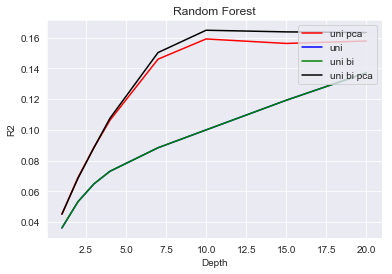

the best R^2 is 0.16485533417605513 with depth=10 and training data: uni & bi with PCA


ValueError: cannot reshape array of size 8 into shape (8,3)

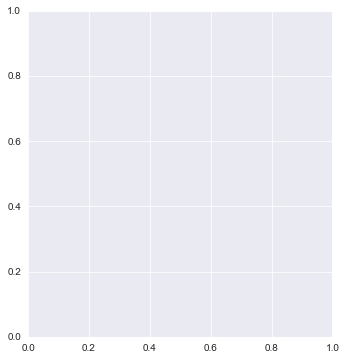

In [24]:
r2_uni, r2_uni_bi, r2_uni_pca, r2_uni_bi_pca = [], [], [], []
max_r2, best_depth, best_training_data = 0, 0, ''

depth = [1,2,3,4,7,10,15,20]
estimators = [10, 100, 1000]
for d in depth:
    #for e in estimators:
    print('depth: ' + str(d) + '  estimators: '+ str(1000))
    model = RandomForestRegressor(n_estimators=1000, max_depth=d, random_state=seed)
    r2_uni.append(train_evaluate(model, X_train_uni, y_train_uni, X_test_uni, y_test_uni)[1])
    if max_r2 < r2_uni[-1]: max_r2, best_depth, best_training_data = r2_uni[-1], d, 'uni'
    r2_uni_bi.append(train_evaluate(model, X_train_uni_bi, y_train_uni_bi, X_test_uni_bi, y_test_uni_bi)[1])
    if max_r2 < r2_uni_bi[-1]: max_r2, best_depth, best_training_data = r2_uni_bi[-1], d, 'uni & bi'
    r2_uni_pca.append(train_evaluate(model, X_train_uni_pca, y_train_uni, X_test_uni_pca, y_test_uni)[1])
    if max_r2 < r2_uni_pca[-1]: max_r2, best_depth, best_training_data = r2_uni_pca[-1], d, 'uni with PCA'
    r2_uni_bi_pca.append(train_evaluate(model, X_train_uni_bi_pca, y_train_uni_bi, X_test_uni_bi_pca, y_test_uni_bi)[1])
    if max_r2 < r2_uni_bi_pca[-1]: max_r2, best_depth, best_training_data = r2_uni_bi_pca[-1], d, 'uni & bi with PCA'

plt.plot(depth,r2_uni_pca,'r', label='uni pca')
plt.plot(depth,r2_uni,'b', label='uni')
plt.plot(depth,r2_uni_bi,'g', label='uni bi')
plt.plot(depth,r2_uni_bi_pca,'k', label='uni bi pca')
plt.legend(loc='upper right', numpoints = 1)
plt.xlabel('Depth')
plt.ylabel('R2')
plt.title('Random Forest')
plt.show()

print('the best R^2 is ' + str(max_r2) + ' with depth=' + str(best_depth) + ' and training data: ' + best_training_data)
        
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
data_r2_uni = pd.DataFrame(np.array(r2_uni).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
ax = sns.heatmap(data_r2_uni, annot =True, fmt='.3g') #cmap="YlGnBu"
plt.title('R^2 uni')
plt.xlabel('# trees')
plt.ylabel('depth')
plt.subplot(1, 2, 2)
data_r2_uni_pca = pd.DataFrame(np.array(r2_uni_pca).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
ax = sns.heatmap(data_r2_uni_pca, annot =True, fmt='.3g') #cmap="YlGnBu"
plt.title('R^2 uni pca')
plt.xlabel('# trees')
plt.ylabel('depth')
plt.tight_layout()
plt.show()

#plt.subplot(1, 2, 1)
#data_r2_uni_bi = pd.DataFrame(np.array(r2_uni_bi).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
#ax = sns.heatmap(data_r2_uni_bi, annot =True, fmt='.3g') #cmap="YlGnBu"
#plt.title('R^2 uni & bi')
#plt.xlabel('# trees')
#plt.ylabel('depth')
#plt.subplot(1, 2, 2)
#data_r2_uni_bi_pca = pd.DataFrame(np.array(r2_uni_bi_pca).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
#ax = sns.heatmap(data_r2_uni_bi_pca, annot =True, fmt='.3g') #cmap="YlGnBu"
#plt.title('R^2 uni & bi pca')
#plt.xlabel('# trees')
#plt.ylabel('depth')
#plt.tight_layout()
#plt.show()
